Importing numpy along with matplotlib.pyplot and various tools from the matplotlib library. The "TKAgg" backend is used along with the %matplotlib notebook in order to allow interactive plots within the notebook

In [2]:
import numpy as np
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib notebook

Functions which define the RK4 routine and the acceleration caused by the charged ring (which is modelled as point particle sections as a approximation to the integration required). Also a function to calculate the SHM frequency found if the displacement of the particle is assumed to be much less than the radius of the ring.

In [3]:
def rk4(R,V,a,h,ring_r,ring_steps,q):
	# Function to time step using the Runge-Kutta 4th order algorithm
	# V - velocity vector of the particle(s)
	# R - position vector of the particle(s)
	# a - function which outputs the acceleration of the particle
	# h - time step size
	# ring_r,ring_steps,q - parameters used in the a() function

	# First
	r_1 = R
	v_1 = V
	a_1 = a(r_1,ring_r,ring_steps,q)

	# Second
	r_2 = r_1 + 0.5*v_1*h
	v_2 = v_1 + 0.5*a_1*h
	a_2 = a(r_2,ring_r,ring_steps,q)

	# Third
	r_3 = r_1 + 0.5*v_2*h
	v_3 = v_1 + 0.5*a_2*h
	a_3 = a(r_3,ring_r,ring_steps,q)

	# Fourth
	r_4 = r_1 + v_3*h
	v_4 = v_1 + a_3*h
	a_4 = a(r_4,ring_r,ring_steps,q)

	# Final position and velocity
	r_f = R + (h/6.0)*(v_1+2*v_2+2*v_3+v_4)
	v_f = V + (h/6.0)*(a_1+2*a_2+2*a_3+a_4)

	return r_f,v_f

def a(R,ring_r,ring_steps,q):
	# Function to calculate the acceleration of the particle(s) at position R
	# R - position vector of the the particle(s)
	# ring_r -  radius of the charged ring
	# q - ratio of the charge on the particle to that on the ring
	# ring_steps - Number of sections of ring considered	

	# Charge density of the ring
	rho = q/(2*np.pi*ring_r)

	# Azimuthal angle steps
	phi_h = 2*np.pi/float(ring_steps)
	
	total_acc = np.array((0.0,0.0,0.0))
	for i in range(ring_steps):
		# Azimuthal angle
		phi = i*phi_h
		# Relative position vector of particle to element of ring dq
		P = R-np.array((ring_r*np.cos(phi),ring_r*np.sin(phi),0))
	
		# Magnitude of the relative position vector
		P_mag = np.linalg.norm(P)

		acc = -ring_r*phi_h*rho*P/(4*np.pi*P_mag**3)

		total_acc = total_acc + acc

	return total_acc

def shm_freq(ring_r,q):
	return (q/(4*np.pi*ring_r**3))**0.5

Animation object, contains the necessary methods to create an interactive animation of the motion of the charged particle near the ring. Sliders are introduced to modify parameters and a run button which will restart the animation for these new parameters. The RK4 routine is run before producing the plotting to allow for a smooth animation.

In [4]:
class Animation(object):

	def __init__(self,q,ring_r,ring_steps,h,N,N_output):
		self.q = q
		self.ring_r = ring_r
		self.ring_steps = ring_steps
		self.h = h
		self.N = N
		self.N_output = N_output

	def create_plot(self,R_i,V_i):
		self.R_i = R_i
		self.V_i = V_i

		self.fig = plt.figure(figsize = plt.figaspect((0.5)))

		self.ax1 = self.fig.add_subplot(1,2,1, projection='3d')
		self.ax1.set_xlim3d([-self.ring_r,self.ring_r])
		self.ax1.set_ylim3d([-self.ring_r,self.ring_r])
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		for i in range(self.ring_steps):
			phi_h = 2*np.pi/float(self.ring_steps)
			x = self.ring_r*np.cos(i*phi_h)
			y = self.ring_r*np.sin(i*phi_h)
			self.ax1.plot([x],[y],[0.0],'bo')

		self.ax2 = self.fig.add_subplot(1,2,2)
		self.ax2.get_xaxis().set_ticks([])
		z_max = self.R_i[2]
		self.ax2.set_xlim([0.0,self.h*self.N])
		self.ax2.set_ylim([-z_max,z_max])

		self.particle = self.ax1.plot([self.R_i[0]],[self.R_i[1]],[self.R_i[2]],'ro')[0]
		self.z_plot = self.ax2.plot([0.0],[z_max],'b-')[0]
		self.z_shm = self.ax2.plot([0.0],[z_max],'r-')[0]

	def create_sliders(self):
		# Positioning of sliders
		axp_s = 0.02
		# Slider index
		si = 0
		# Slider width
		sw = 0.02
		
		# Starting height of particle slider
		self.ax_h = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		self.s_h = Slider(self.ax_h,'Particle Height',0.001,2.5, valinit= self.R_i[2])
		self.s_h.on_changed(self.update)
		si = si+1

		# Charge factor slider
		self.ax_q = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		self.s_q = Slider(self.ax_q,'Charge Factor',500.0,10000.0, valinit = self.q)
		self.s_q.on_changed(self.update)
		si = si+1

		# Run button
		self.ax_b = plt.axes([0.15,1.0 - (0.04+sw),0.65,1.5*sw])
		self.b_run = Button(self.ax_b,'Run (with new values)')
		self.b_run.on_clicked(self.mainloop)
		
		plt.show()

	def run_anim(self,R_rec,V_rec):

		self.R = R_rec
		self.V = V_rec
		self.ax2.set_ylim([-self.R_i[2],self.R_i[2]])
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		self.shm_f = shm_freq(self.ring_r,self.q)

		# Animation functions
		def nextframe(arg):
			self.particle.set_data(self.R[0:2,arg])
			self.particle.set_3d_properties(self.R[2,arg])

			frame_num = arg+1
			time = np.linspace(0.0,self.h*self.N_output*arg,frame_num)
			self.z_plot.set_data(time,self.R[2,:frame_num])
			self.z_shm.set_data(time,self.R[2,0]*np.cos(self.shm_f*time))
		try:
			self.animate._stop()
		except:
			print('No FuncAnimation to stop')
		self.animate = anim.FuncAnimation(self.fig, nextframe, self.N/self.N_output, interval = 100, blit = False)
		plt.show()

	def update(self,val):
		self.q = self.s_q.val
		self.R_i = np.array((self.R_i[0],self.R_i[1],self.s_h.val))

	def mainloop(self,event):
		print('Commencing RK4 routine...')
		
		R = np.zeros((3))
		V = np.zeros((3))
		R = self.R_i
		V = self.V_i

		# Record arrays:
		R_rec = np.zeros((3,N/N_output))
		V_rec = np.zeros((3,N/N_output))
		i_rec = 0
		for i in range(N):
			R,V = rk4(R,V,a,self.h,self.ring_r,self.ring_steps,self.q)
			if (i%N_output) == 0:
				R_rec[:,i_rec] = R
				V_rec[:,i_rec] = V
				i_rec = i_rec + 1

		print('RK4 time stepping has been completed')

		self.run_anim(R_rec,V_rec)

Contains the necessary initial parameters and creates an Animation object for the user to interact with. Off axis starting positions can be investigated by changing the R vector, where the components represent (x,y,z), below.

<IPython.core.display.Javascript object>


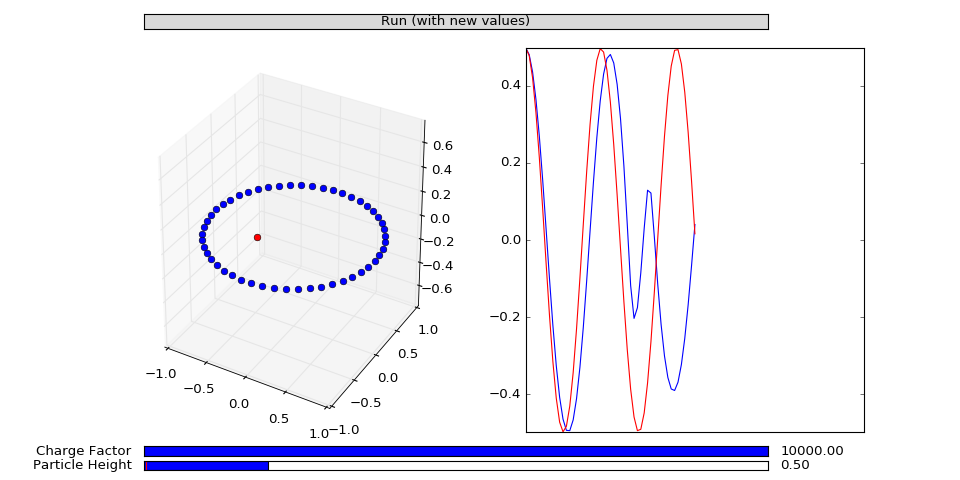

In [6]:
# initial conditions
# Particle position and velocity
R = np.array((0.01,0.01,0.01))
V = np.array((0.0,0.0,0.0))

# Ring radius
ring_r = 1.0
# Ring sections
ring_steps = 50
# Charge factor = qQ/epsilon_0
q = 10000.0

# Time step
h = 10.0**-3
N = 1000

# Animation frame change
N_output = 10

Anim = Animation(q,ring_r,ring_steps,h,N,N_output)
Anim.create_plot(R,V)
Anim.create_sliders()

The left hand graph shows the position of the particle in red and the ring in blue. The right hand graph shows the z value of the particle as a function of time (blue for actual position and red shows SHM approximation). The two sliders control the charge factor (q Q / epsilon_0) and the height from which the particle is dropped.

For small particle heights the SHM approximation is very good but as this becomes comparable to the the size of the ring then it breaks down.

Some interesting/fun simulations to try:
    Initial position R = (0.01,0.01,0.5)
    Initial velocity - at rest
    Charge factor 10,000
    Ring sections 50 and ring radius 1
-> This produces some nice looping motion about the ring.